# HSE 2021: Mathematical Methods for Data Analysis

## Homework 3

**Warning 1**: some problems require (especially the lemmatization part) significant amount of time, so **it is better to start early (!)**

**Warning 2**: it is critical to describe and explain what you are doing and why, use markdown cells

In [5]:
from typing import Tuple, List

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
%matplotlib inline

sns.set(style="darkgrid")

## PART 1: Logit model

We consider a binary classification problem. For prediction, we would like to use a logistic regression model. For regularization we add a combination of the $l_2$ and $l_1$ penalties (Elastic Net).

Each object in the training dataset is indexed with $i$ and described by pair: features $x_i\in\mathbb{R}^{K}$ and binary labels $y_i$. The model parametrized with bias $w_0\in\mathbb{R}$ and weights $w\in\mathbb{R}^K$.

The optimization problem with respect to the $w_0, w$ is the following (Elastic Net Loss):

$$L(w, w_0) = \frac{1}{N} \sum_{i=1}^N \ln(1+\exp(-y_i(w^\top x_i+w_0))) + \gamma \|w\|_1 + \beta \|w\|_2^2$$.

#### 1. [0.5 points]  Find the gradient of the Elastic Net loss and write its formulas (better in latex format)


##### Put your markdown formulas here

$$\nabla_w L(w,w_0)= -\frac{1}{N} \sum_i^N \frac{y_i x_iexp(-y_i (w^Tx_i+w_0))}{1+exp(-y_i (w^Tx_i+w_0))} + \gamma sign(w)+ 2 \cdot \beta \cdot w$$

$$\nabla_{w_0} L(w,w_0)= -\frac{1}{N} \sum_i^N \frac{y_iexp(-y_i (w^Tx_i+w_0))}{1+exp(-y_i (w^Tx_i+w_0))} $$


#### 2. [0.25 points] Implement the Elastic Net loss (as a function)

In [6]:
def loss(X, y, w: List[float], w0: float, gamma=1., beta=1.) -> float:
    return 1 / len(X) * np.sum(np.log(np.exp(-y * (w0 + np.dot(X, np.transpose(w))))) + np.log(1)) + np.linalg.norm(
        w) * beta + np.sum(np.linalg.norm(w)) * gamma

#### 3. [0.25 points] Implement the gradient (as a function)

In [7]:
def tmp_grad(X, w, w0, y):
    return 1 + np.exp(y * (w0 + (np.dot(w, X.T))))


def get_grad(X, y, w: List[float], w0: float, gamma=1., beta=1.) -> Tuple[List[float], float]:
    grad_w0 = (y * 1 / tmp_grad(X, w, w0, y)).mean()
    grad_w = (1 / len(y) * (np.dot((-y) / tmp_grad(X, w, w0, y), X))) + 2 * beta * w + gamma * np.sign(w)
    return grad_w, -grad_w0

#### Check yourself

In [8]:
np.random.seed(42)
X = np.random.multivariate_normal(np.arange(5), np.eye(5), size=10)
y = np.random.binomial(1, 0.42, size=10)
w, w0 = np.random.normal(size=5), np.random.normal()

grad_w, grad_w0 = get_grad(X, y, w, w0)
print(grad_w)
print(grad_w0)
assert (np.allclose(grad_w,
                    [-2.73262076, -1.87176281, 1.30051144, 2.53598941, -2.71198109],
                    rtol=1e-2) & np.allclose(grad_w0,
                                             -0.2078231418067844,
                                             rtol=1e-2)
        )

[-2.73262181 -1.87176392  1.30051023  2.53598816 -2.71198278]
-0.20782319347690742


####  4. [1 point]  Implement gradient descent which works for both tol level and max_iter stop criteria and plot the decision boundary of the result

The template provides basic sklearn API class. You are free to modify it in any convenient way.

In [9]:
from sklearn.base import BaseEstimator, ClassifierMixin

In [10]:
from sklearn.metrics import roc_curve
import numpy as np


class Logit(BaseEstimator, ClassifierMixin):

    def __init__(self, beta=1.0, gamma=1.0, lr=1e-2, tolerance=1e-8, max_iter=10000, random_state=42):
        self.check_tol = None
        self.w = None
        self.w0 = None
        self.threshold = 0.5  #по умолчанию если не менять пороги классификации
        self.tolerance = 1e-8
        self.beta = beta
        self.gamma = gamma
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.learning_rate = lr  # можно вернуть на 1е-2
        self.random_state = random_state
        self.negative = -1
        self.positive = 1
        self.lh = []

    def editing_loss(self):
        self.lh.append(loss(X, y, self.w, self.w0, self.gamma, self.beta))

    def add_settings(self):
        np.random.seed(self.random_state)
        self.lh = []
        self.w = np.random.sample(X.shape[1])
        self.w0 = np.random.normal()

    def fit(self, X, y):
        self.add_settings()
        for iteration in range(self.max_iter):
            # print(iteration)
            # print()
            grad_w, grad_w0 = get_grad(X, y, self.w, self.w0, self.gamma, self.beta)
            self.w -= self.learning_rate * grad_w
            self.w0 -= self.learning_rate * grad_w0
            self.check_tol = -self.learning_rate * grad_w
            self.editing_loss()
            if np.linalg.norm(self.check_tol) < self.tolerance:
                break

        # probabilities_valid = self.predict_proba(X)
        # probabilities_one_valid = probabilities_valid[:, 1]
        return self

    def predict(self, X):
        if self.w is None:
            raise Exception('Not trained yet')
        predict, useless = self.predict_proba(X)
        predict = np.where(predict <= self.threshold, self.negative, self.positive)
        return predict

    def predict_proba(self, X):
        return np.array([1 / (1 + np.exp(np.dot(X, self.w) + self.w0)), 1 / (1 + np.exp(-np.dot(X, self.w) - self.w0))])


In [11]:
# sample data to test your model
from sklearn.datasets import make_classification

X, y = make_classification(n_samples=180, n_features=2, n_redundant=0, n_informative=2,
                           random_state=42, n_clusters_per_class=1)

In [12]:
# a function to plot the decision boundary
def plot_decision_boundary(model, X, y):
    fig = plt.figure()
    X1min, X2min = X.min(axis=0)
    X1max, X2max = X.max(axis=0)
    x1, x2 = np.meshgrid(np.linspace(X1min, X1max, 200),
                         np.linspace(X2min, X2max, 200))
    ypred = model.predict(np.c_[x1.ravel(), x2.ravel()])
    ypred = ypred.reshape(x1.shape)

    plt.contourf(x1, x2, ypred, alpha=.4)
    plt.scatter(X[:, 0], X[:, 1], c=y)

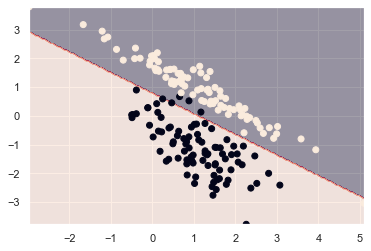

In [13]:
model = Logit(0, 0)
y[y == 0] = -1
model.fit(X, y)
plot_decision_boundary(model, X, y)

#### 5. [0.25 points] Plot loss diagram for the model, i.e. show the dependence of the loss function from the gradient descent steps

[-0.9938790639017848, -0.996361898853372, -0.9988328071363615, -1.001291888305608, -1.003739241101138, -1.006174963447453, -1.0085991524531772, -1.0110119044110435, -1.0134133147981998, -1.0158034782768295, -1.018182488695066, -1.0205504390881985, -1.022907421680152, -1.02525352788523, -1.0275888483101125, -1.0299134727560975, -1.0322274902215696, -1.0345309889046965, -1.0368240562063322, -1.0391067787331245, -1.041379242300813, -1.043641531937712, -1.0458937318883657, -1.048135925617368, -1.05036819581334, -1.0525906243930547, -1.0548032925057012, -1.057006280537282, -1.0591996681151339, -1.061383534112566, -1.063557956653609, -1.065723013117864, -1.0678787801454528, -1.0700253336420515, -1.0721627487840137, -1.074291100023568, -1.0764104610940868, -1.0785209050154223, -1.0806225040993043, -1.0827153299547898, -1.0847994534937655, -1.086874944936496, -1.0889418738172114, -1.0910003089897315, -1.0930503186331244, -1.0950919702573882, -1.0971253307091617, -1.0991504661774518, -1.1011674

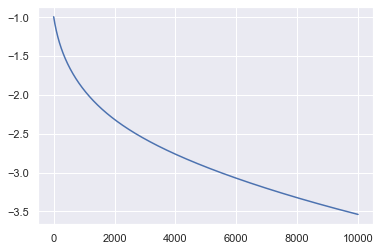

In [14]:
print(model.lh)
plt.plot(model.lh)

## PART 2: Support Vector Machines

#### 6. [2 point] Using the same dataset, train SVM Classifier from Sklearn.
Investigate how different parameters influence the quality of the solution:
+ Try several kernels: Linear, Polynomial, RBF (and others if you wish). Some Kernels have hypermeters: don't forget to try different.
+ Regularization coefficient

Show how these parameters affect accuracy, roc_auc and f1 score.
Make plots for the dependencies between metrics and parameters.
Try to formulate conclusions from the observations. How sensitive are kernels to hyperparameters? How sensitive is a solution to the regularization? Which kernel is prone to overfitting?

In [15]:
my_accuracy_linear = list()
my_accuracy_poly = list()
my_accuracy_rbf = list()

my_auc_roc_linear = list()
my_auc_roc_poly = list()
my_auc_roc_rbf = list()

my_f1_linear = list()
my_f1_poly = list()
my_f1_rbf = list()


In [16]:
from sklearn.svm import SVC


def svm_kernels(features_train, features_valid, target_train, target_valid, kernel):
    for iter in np.linspace(0.0005, 5, 1000):
        model = SVC(kernel=kernel, C=iter)
        model.fit(features_train, target_train)
        predicted = model.predict(features_valid)
        if kernel == 'linear':
            # for linear
            my_accuracy_linear.append(accuracy_score(target_valid, predicted))
            my_auc_roc_linear.append(roc_auc_score(target_valid, predicted))
            my_f1_linear.append(f1_score(target_valid, predicted))
        elif kernel == 'poly':
            # for poly
            my_accuracy_poly.append(accuracy_score(target_valid, predicted))
            my_auc_roc_poly.append(roc_auc_score(target_valid, predicted))
            my_f1_poly.append(f1_score(target_valid, predicted))
        else:
            # for rbf
            my_accuracy_rbf.append(accuracy_score(target_valid, predicted))
            my_auc_roc_rbf.append(roc_auc_score(target_valid, predicted))
            my_f1_rbf.append(f1_score(target_valid, predicted))


In [17]:
features_train, features_valid, target_train, target_valid = train_test_split(X, y, test_size=0.25, random_state=12345)

In [18]:
svm_kernels(features_train, features_valid, target_train, target_valid, 'linear')
svm_kernels(features_train, features_valid, target_train, target_valid, 'poly')
svm_kernels(features_train, features_valid, target_train, target_valid, 'rbf')

In [19]:
print(my_accuracy_linear)
print(my_accuracy_poly)
print(my_accuracy_rbf)

[0.4666666666666667, 0.8444444444444444, 0.9111111111111111, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.9555555555555556, 0.9555555555555556, 0.9555555555555556, 0.9555555555555556, 0.9555555555555556, 0.9555555555555556, 0.9555555555555556, 0.9555555555555556, 0.9555555555555556, 0.9555555555555556, 0.9555555555555556, 0.9555555555555556, 0.9555555555555556, 0.9555555555555556, 0.9555555555555556, 0.9555555555555556, 0.9555555555555556, 0.9555555555555556, 0.9555555555555556, 0.9555555555555556, 0.9555555555555556, 0.9555555555555556, 0.9555555555555556, 0.9555555555555556, 0.9555555555555556, 0.9555555555555556, 0.9555555555555556, 0.9555555555555556, 0.9555555555555556, 0.9555555555555556, 0.9555555555555556, 0.9555555555555556, 0.9555555555555556, 0.9555555555555556, 0.9555555555555556, 0.9555555555555556, 0.9555555555555556, 0.9555555555555556, 0.9555555555555556, 0.9555555555555556, 0.9555555555555556, 0.9555555555555556, 0.9555555555555556,

Accuracy


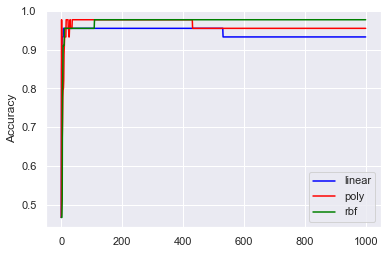

AUC ROC


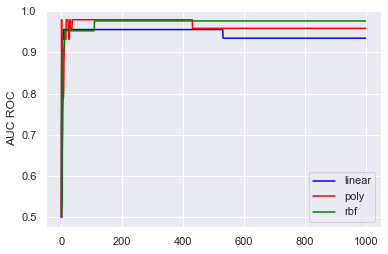

F1


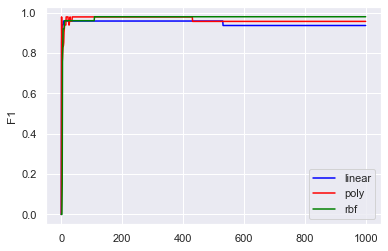

In [20]:
fig, ax1 = plt.subplots()
print("Accuracy")
ax1.plot(my_accuracy_linear, label='linear', color='blue')
ax1.plot(my_accuracy_poly, label='poly', color='red')
ax1.plot(my_accuracy_rbf, label='rbf', color='green')
ax1.legend()
ax1.set_ylabel("Accuracy")
plt.show()
print('AUC ROC')
fig, ax2 = plt.subplots()
ax2.plot(my_auc_roc_linear, label='linear', color='blue')
ax2.plot(my_auc_roc_poly, label='poly', color='red')
ax2.plot(my_auc_roc_rbf, label='rbf', color='green')
ax2.legend()
ax2.set_ylabel("AUC ROC")
plt.show()
print('F1')
fig, ax3 = plt.subplots()
ax3.plot(my_f1_linear, label='linear', color='blue')
ax3.plot(my_f1_poly, label='poly', color='red')
ax3.plot(my_f1_rbf, label='rbf', color='green')
ax3.set_ylabel("F1")
plt.legend()
plt.show()

## PART 3: Natural Language Processing

#### 7. [1.75 point] Form the dataset

We are going to form a dataset that we will use in the following tasks for binary and multiclass classification

0. Choose **six** authors that you like (specify who you've chosen) and download the <a href="https://www.kaggle.com/d0rj3228/russian-literature?select=prose">relevant data</a> from **prose** section
1. Build your own dataset for these authors:
    * divide each text into sentences such that we will have two columns: *sentence* and *target author*, each row will contain one sentence and one target
    * drop sentences where N symbols in a sentence < 15
    * fix random state and randomly choose sentences in the folowing proportion "5k : 15k : 8k : 11k : 20k : 3k" for the authors respectively

    sample data may look like:

    <center>
    <table>
        <tr>
            <th> sentence </th>
            <th> author </th>
        </tr>
        <tr><td> Несколько лет тому назад в одном из своих поместий жил старинный русской барин, Кирила Петрович Троекуров. </td><td> Пушкин </td><td>
        <tr><td> Уже более недели приезжий господин жил в городе, разъезжая по вечеринкам и обедам и таким образом проводя, как говорится, очень приятно время. </td><td> Гоголь </td><td>
        <tr><td> ... </td><td> ... </td><td>
        <tr><td> Я жил недорослем, гоняя голубей и играя в чехарду с дворовыми мальчишками. </td><td> Пушкин </td><td>
    </table>
</center>

2. Preprocess (tokenize and clean) the dataset
    * tokenize, remove all stop words (nltk.corpus.stopwords), punctuation (string.punctuation) and numbers
    * convert to lower case and apply either stemming or lemmatization of the words (on your choice)
    * vectorize words using both **bag of words** and **tf-idf** (use sklearn)
    * observe and describe the difference between vectorized output (what do numbers look like after transformations and what do they represent?)

Chosen authors: Gogol, Herzen, Turgenev, Tolstoy, Pushkin and Blok

In [21]:
import glob
import pandas as pd

In [22]:
fold = 'D:/PY/dsProject1/hse/book/archive/prose'
my_authors = ['Gogol', 'Herzen', 'Turgenev', 'Tolstoy', 'Pushkin', 'Blok']

features_sent = []
for author in my_authors:
    tmp_sent = []
    for filename in glob.glob(fold + '/' + author + '/*.txt'):
        data_text = []
        with open(filename, 'r', encoding="utf-8") as file:
            data_text = file.read()
        data_text = data_text.replace('\n', ' ').split('.')
        # for i in range(len(data_text)):
        #     if len(data_text[i]) <= 15:
        #         data_text.pop(i)
        data_text = [data_text[i] for i in range(len(data_text)) if len(
            data_text[i]) >= 15]  # конечно из-за того, что list comr удобно откинуть длину 15, но будет списком
        tmp_sent.extend(data_text)
    features_sent.append(tmp_sent)
display(pd.Series(my_authors), pd.Series(features_sent))

0       Gogol
1      Herzen
2    Turgenev
3     Tolstoy
4     Pushkin
5        Blok
dtype: object

0    [ Николай Васильевич Гоголь Ревизор  На зеркал...
1    [СЫНУ МОЕМУ АЛЕКСАНДРУ        Друг мой Саша,  ...
2    [ Иван Сергеевич Тургенев Стихотворения в проз...
3    [ Толстой РУБКА ЛЕСА,  РАССКАЗ ЮНКЕРА,      В ...
4    [Александр Пушкин РОСЛАВЛЕВ Читая «Рославлева»...
5    [Сограждане     Болото вымостили булыжником,  ...
dtype: object

In [23]:
#"5k : 15k : 8k : 11k : 20k : 3k"

tmp = 5 + 15 + 8 + 11 + 20 + 3
k = 100 / tmp


def randomly_choose(element, koef):
    element = pd.Series(element)
    return element.sample(frac=koef * k / 100, replace=True, random_state=12345)


features_sent[0] = randomly_choose(features_sent[0], 5)
features_sent[1] = randomly_choose(features_sent[1], 15)
features_sent[2] = randomly_choose(features_sent[2], 8)
features_sent[3] = randomly_choose(features_sent[3], 11)
features_sent[4] = randomly_choose(features_sent[4], 20)
features_sent[5] = randomly_choose(features_sent[5], 3)

display(pd.Series(my_authors), pd.Series(features_sent))

0       Gogol
1      Herzen
2    Turgenev
3     Tolstoy
4     Pushkin
5        Blok
dtype: object

0    11749     Везде было заметно такое чуть-чуть о...
1    4578           С  самой  первой юности Анатоль...
2    11749     Дрожки прыгали по твердым корням сто...
3    86498     Народу сбежалось бездна, все кричали...
4    4578     Пугачев велел раздать чувашам казенно...
5    285        "Православны" ли они, тупы ли? Дума...
dtype: object

In [24]:
from sklearn.utils import shuffle
import random

data = pd.DataFrame([], columns=['sentence', 'author'])

# print(features_sent[0])
print()


def creating_data(i, sentence, author):
    tmp_sent_for_each_author = sentence
    tmp_author_for_each_author = list()
    for i in range(len(tmp_sent_for_each_author)):
        tmp_author_for_each_author.append(author)
    tmp_data_for_each_author = pd.DataFrame()
    tmp_data_for_each_author['sentence'] = list(tmp_sent_for_each_author)
    tmp_data_for_each_author['author'] = tmp_author_for_each_author
    return tmp_data_for_each_author


for i in range(len(my_authors)):
    data = pd.concat(
        [data] + [creating_data(i, features_sent[i], my_authors[i])
                  ])
data = shuffle(data, random_state=42)
data = data.reset_index(drop=True)
display(data)

,sentence,author
0,- Кто-то ехал на ослице в черном платье; он ...,Herzen
1,"Не будет тебе ни замка, ни закладки",Tolstoy
2,"– Да, вы достигли всех ваших целей, – промолв...",Turgenev
3,"Вот эти господа для чего ездят? – сказал он, ...",Tolstoy
4,Я выбрал это место с самого начала,Tolstoy
...,...,...
24663,Покоримся воле его,Tolstoy
24664,"И руки у всех были дворянские, белые, большие...",Turgenev
24665,Везде уловлена была эта плывучая округлость л...,Gogol
24666,"– Да, он пишет, что вы переехали, и думает, ...",Tolstoy


Using seminar 6 code.

In [25]:
import string  # for work with strings
import nltk  # Natural Language Toolkit

In [26]:
# get russian stop words
nltk.download('stopwords')
stop_words = nltk.corpus.stopwords.words('russian')

# example of stop words
stop_words[:10]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со']

In [27]:
word_tokenizer = nltk.WordPunctTokenizer()

In [28]:
dates = [str(x) for x in np.arange(1900, 2022)]


def process_data(data):
    words = []
    for sentence in data['sentence']:
        # collect nlabels of news
        sentence_lower = sentence.lower()  # convert words in a text to lower case
        tokens = word_tokenizer.tokenize(sentence_lower)  # splits the text into tokens (words)
        # remove punct and stop words from tokens
        tokens = [word for word in tokens if
                  (word not in string.punctuation and word not in stop_words and word not in dates)]
        words.append(tokens)  # collect the text tokens
    return words

In [29]:
words = process_data(data)
display(words)
print()
words[:3]
print("Tokens: ", words[:5])

[['ехал', 'ослице', 'черном', 'платье', 'спускал', 'глаз', 'это', 'монах'],
 ['тебе', 'замка', 'закладки'],
 ['–', 'достигли', 'ваших', 'целей', '–', 'промолвил', 'федор', 'иваныч'],
 ['господа',
  'ездят',
  '–',
  'сказал',
  'указывая',
  'ядовитого',
  'господина',
  'который',
  'говорил',
  'губернским',
  'столом'],
 ['выбрал', 'это', 'место', 'самого', 'начала'],
 ['хлеба', 'ради', 'христа', 'хлеба'],
 ['–',
  'такое',
  'другого',
  'оно',
  'старое',
  'гадкое',
  'принуждена',
  'надевать',
  'это',
  'платье',
  'каждый',
  'день',
  '…',
  '…',
  'приходите',
  '…',
  'разлюбишь',
  'видя',
  'замарашкой',
  '–',
  'помилуй',
  'ирина',
  'говоришь',
  'платье',
  'это',
  'премилое',
  '…',
  'оно',
  'дорого',
  'первый',
  'нем',
  'видел'],
 ['наташа', 'петербурге'],
 ['любил',
  'помечтать',
  'деревенская',
  'жизнь',
  'развила',
  'нем',
  'способность'],
 ['прошло',
  'пять',
  'лет',
  'тех',
  'пор',
  'принял',
  'должность',
  'старшего',
  'учителя',
  'завед


Tokens:  [['ехал', 'ослице', 'черном', 'платье', 'спускал', 'глаз', 'это', 'монах'], ['тебе', 'замка', 'закладки'], ['–', 'достигли', 'ваших', 'целей', '–', 'промолвил', 'федор', 'иваныч'], ['господа', 'ездят', '–', 'сказал', 'указывая', 'ядовитого', 'господина', 'который', 'говорил', 'губернским', 'столом'], ['выбрал', 'это', 'место', 'самого', 'начала']]


In [30]:
! pip install pymorphy2

In [31]:
% % time
import pymorphy2

morph = pymorphy2.MorphAnalyzer()

morph_word = []
for aword in words:
    # aword_norm = morph.parse(aword)[0].normal_form
    morph_word.append([morph.parse(word)[0].normal_form for word in aword])
    # print("Before: %s, After: %s" % (aword, aword_norm))
morph_word[:5]

UsageError: Line magic function `%` not found.


In [ ]:
upgrade_morph_sent = []
tmp_morph_sent = str()
for word in morph_word:
    tmp_morph_sent = ''
    for morph_1 in word:
        tmp_morph_sent += morph_1 + ' '
    upgrade_morph_sent.append(tmp_morph_sent)
data['morph_sentence'] = upgrade_morph_sent
display(data)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(max_features=50)
vectorizer.fit(list(data['morph_sentence']))

# The top 10 words
vectorizer.get_feature_names()[:10]

In [ ]:
bag = vectorizer.transform(data['morph_sentence'])
bag.todense()[:5]



In [ ]:
#calc tf-idf
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer

# Fit TF-IDF on train texts
vectorizer = TfidfVectorizer(max_features=100)  # select the top 100 words
vectorizer.fit(data['morph_sentence'])

# The top 10 words
vectorizer.get_feature_names()[:10]

In [ ]:
td_idf_sentences = vectorizer.transform(data['morph_sentence'])
td_idf_sentences.todense()[:5]

###  Binary classification

#### 8. [2 point] Train model using Logistic Regression (your own) and SVC (SVM can be taken from sklearn)

* choose *two* authors from the dataset that you have formed in the previous task
* check the balance of the classes
* divide the data into train and test samples with 0.7 split rate (don't forget to fix the random state)
* using GridSearchCV - find the best parameters for the models (by F1 score) and use it in the next tasks
* make several plots to address the dependence between F1 score and parameters
* plot confusion matrixfor train and test samples
* compute some relevant metrics for test sample (useful to check the seminars 5 and 6, use sklearn)
* make conclusions about the performance of your models


In [ ]:
# your code here
two = ['Gogol']
new_data = data.query('author in ["Pushkin", "Herzen"]')
display(new_data)

In [ ]:
display(new_data['author'].value_counts(normalize=True))

In [ ]:
features_train, features_valid, target_train, target_valid = train_test_split(new_data['morph_sentence'],
                                                                              new_data['author'],
                                                                              stratify=new_data['author'],
                                                                              test_size=0.3, random_state=12345)

#### 9. [1 point] Analysing ROC AUC

It is possible to control the proportion of statistical errors of different types using different thresholds for choosing a class. Plot ROC curves for Logistic Regression and SVC, show the threshold on ROC curve plots. Choose such a threshold that your models have no more than 30% of false positive errors rate. Pay attention to `thresholds` parameter in sklearn roc_curve

In [ ]:
# your code here

### Multiclass logit

#### 10. [1 point] Take the One-VS-One classifier (use sklearn) and apply to Logit model (one you've made in the 4th task) in order to get multiclass linear classifier

<a href="https://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsOneClassifier.html">OneVsOneClassifier</a>

* use the data you got at the previous step for 6 authors
* divide the data into train and test samples with 0.7 split rate
* using GridSearchCV - find the best parameters for the models (by F1 score)
* plot confusion matrix for train and test samples
* compute all possible and relevant metrics for test sample (use sklearn)

In [ ]:
# your code here